In [62]:
# 绘制聚类结果
import matplotlib.pyplot as plt

# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

In [63]:
import pandas as pd

# 读取数据
df = pd.read_csv('data_processed_male.csv')

In [64]:
# 1. 筛选男胎孕妇（Y染色体浓度非空，BMI非空）
df = df[(df['Y染色体浓度'].notna()) & (df['孕妇BMI'].notna())].copy()

df['孕周_float'] = df['检测孕周_周数']
df['BMI'] = df['孕妇BMI'].astype(float)  # 确保BMI是float类型

In [65]:
df = df[['孕妇代码', '检测孕周_周数', 'BMI','Y染色体浓度']]
df

,孕妇代码,检测孕周_周数,BMI,Y染色体浓度
0,A001,11.857143,28.125000,0.025936
1,A001,15.857143,28.515625,0.034887
2,A001,20.142857,28.515625,0.066171
3,A001,22.857143,28.906250,0.061192
4,A002,13.857143,33.331832,0.059230
...,...,...,...,...
882,A266,17.714286,32.969881,0.099052
883,A267,11.571429,30.703133,0.098706
884,A267,12.571429,30.825814,0.102088
885,A267,13.571429,31.107551,0.109855


## 平滑插值

问题：部分数据空格很大

In [66]:

def show_plts(df):
    # 选择5个孕妇（如果数据多，可以用 sample）
    selected_codes = df['孕妇代码'].unique()[:5]
    df_selected = df[df['孕妇代码'].isin(selected_codes)]
    # 绘制 Y染色体浓度 vs 孕周
    plt.figure(figsize=(8, 5))
    for code, group in df_selected.groupby('孕妇代码'):
        plt.plot(group['检测孕周_周数'], group['Y染色体浓度'], marker='o', label=code)
    plt.xlabel('检测孕周（周）')
    plt.ylabel('Y染色体浓度')
    plt.title('Y染色体浓度随孕周变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # 绘制 BMI vs 孕周
    plt.figure(figsize=(8, 5))
    for code, group in df_selected.groupby('孕妇代码'):
        plt.plot(group['检测孕周_周数'], group['BMI'], marker='o', label=code)
    plt.xlabel('检测孕周（周）')
    plt.ylabel('BMI')
    plt.title('BMI随孕周变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


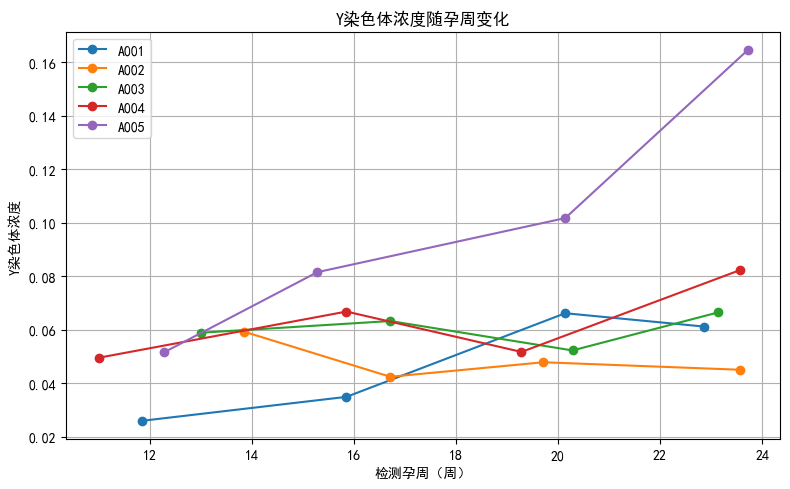

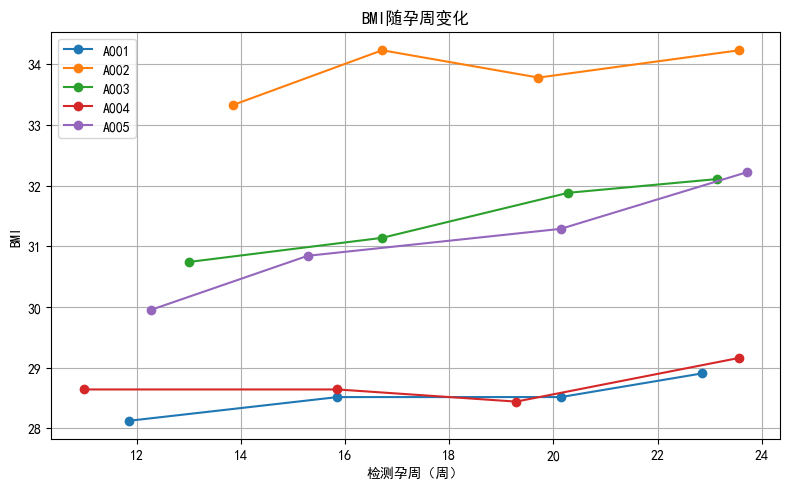

In [67]:
show_plts(df)

In [68]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# 确保排序
df = df.sort_values(['孕妇代码', '检测孕周_周数'])

def smooth_interpolate(group, step=0.5, extend_before=1.0, extend_after=1.0):
    pid = group['孕妇代码'].iloc[0]
    
    # 按孕周排序
    group = group.sort_values('检测孕周_周数')
    
    # 如果有重复孕周，取均值
    group = group.groupby('检测孕周_周数', as_index=False).agg({
        'BMI': 'mean',
        'Y染色体浓度': 'mean'
    })
    
    weeks = group['检测孕周_周数'].values
    bmi = group['BMI'].values
    y_chr = group['Y染色体浓度'].values
    
    if len(weeks) < 2:
        group['孕妇代码'] = pid
        return group[['孕妇代码', '检测孕周_周数', 'BMI', 'Y染色体浓度']]
    
    # 生成扩展后的孕周序列
    start_week = max(0, weeks.min() - extend_before)  # 保证不小于0
    end_week = weeks.max() + extend_after
    full_weeks = np.arange(start_week, end_week + step, step)
    
    # 三次样条插值 + 外推
    bmi_spline = CubicSpline(weeks, bmi, extrapolate=True)
    y_spline = CubicSpline(weeks, y_chr, extrapolate=True)
    
    return pd.DataFrame({
        '孕妇代码': pid,
        '检测孕周_周数': full_weeks,
        'BMI': bmi_spline(full_weeks),
        'Y染色体浓度': y_spline(full_weeks)
    })

# 分组插值
result_df = df.groupby('孕妇代码', group_keys=False).apply(
    smooth_interpolate, step=0.5, extend_before=1.2, extend_after=1.2
).reset_index(drop=True)

print(result_df.head(20))


    孕妇代码    检测孕周_周数        BMI    Y染色体浓度
0   A001  10.657143  27.760218  0.037372
1   A001  11.157143  27.930935  0.031528
2   A001  11.657143  28.074609  0.027243
3   A001  12.157143  28.193444  0.024385
4   A001  12.657143  28.289647  0.022825
5   A001  13.157143  28.365423  0.022430
6   A001  13.657143  28.422976  0.023071
7   A001  14.157143  28.464512  0.024618
8   A001  14.657143  28.492238  0.026939
9   A001  15.157143  28.508357  0.029903
10  A001  15.657143  28.515076  0.033381
11  A001  16.157143  28.514599  0.037242
12  A001  16.657143  28.509133  0.041354
13  A001  17.157143  28.500882  0.045588
14  A001  17.657143  28.492051  0.049812
15  A001  18.157143  28.484847  0.053897
16  A001  18.657143  28.481475  0.057711
17  A001  19.157143  28.484139  0.061124
18  A001  19.657143  28.495046  0.064005
19  A001  20.157143  28.516400  0.066224


C:\Users\heerh\AppData\Local\Temp\ipykernel_18872\1110047518.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('孕妇代码', group_keys=False).apply(


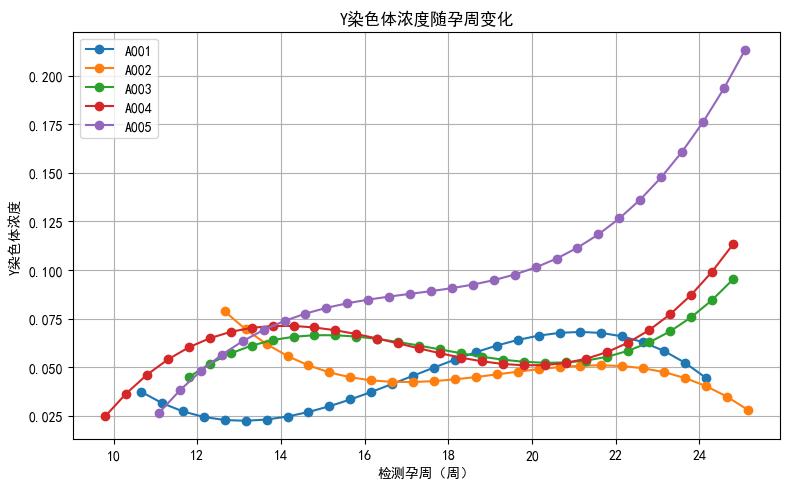

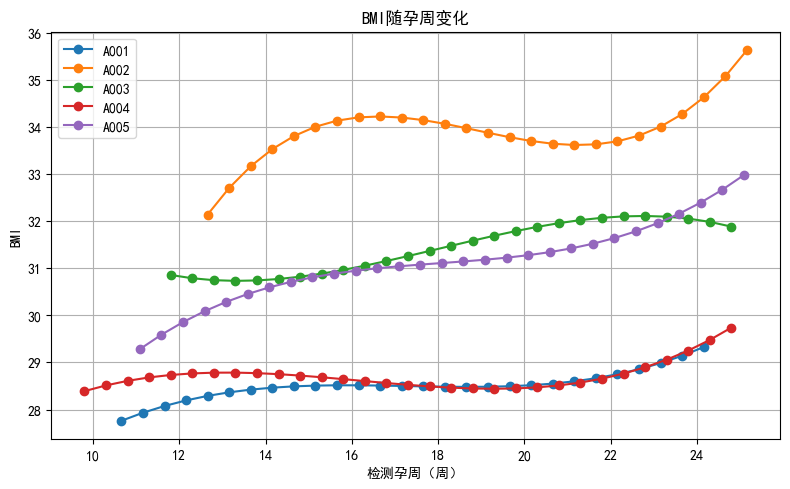

In [69]:
show_plts(result_df)

In [70]:
# 3. 找到每个孕妇的最早达标时间，同时显示BMI列
threshold = 0.04  # 4%
earliest_times = result_df[(result_df['Y染色体浓度'] >= threshold)] \
    .groupby('孕妇代码')[['检测孕周_周数','BMI']].min()
earliest_times

,检测孕周_周数,BMI
孕妇代码,,
A001,16.657143,28.481475
A002,12.657143,32.147846
A003,11.800000,30.736396
A004,10.800000,28.440957
A005,12.085714,29.858763
...,...,...
A263,11.371429,28.863453
A264,10.514286,32.448135
A265,10.514286,33.262688


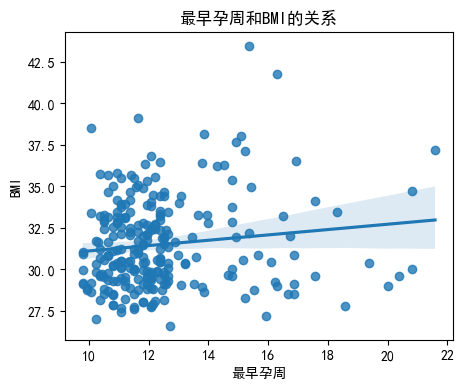

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
# 孕周和BMI的关系
plt.figure(figsize=(5, 4))
sns.regplot(x='检测孕周_周数', y='BMI', data=earliest_times)
plt.xlabel('最早孕周')
plt.ylabel('BMI')
plt.title('最早孕周和BMI的关系')
plt.show()


In [72]:
earliest_times.rename(columns={'检测孕周_周数': '最早达标孕周'}, inplace=True)

print(earliest_times)


         最早达标孕周        BMI
孕妇代码                      
A001  16.657143  28.481475
A002  12.657143  32.147846
A003  11.800000  30.736396
A004  10.800000  28.440957
A005  12.085714  29.858763
...         ...        ...
A263  11.371429  28.863453
A264  10.514286  32.448135
A265  10.514286  33.262688
A266  12.514286  31.884659
A267  10.371429  30.695572

[252 rows x 2 columns]


In [73]:
df_unique = earliest_times.copy()

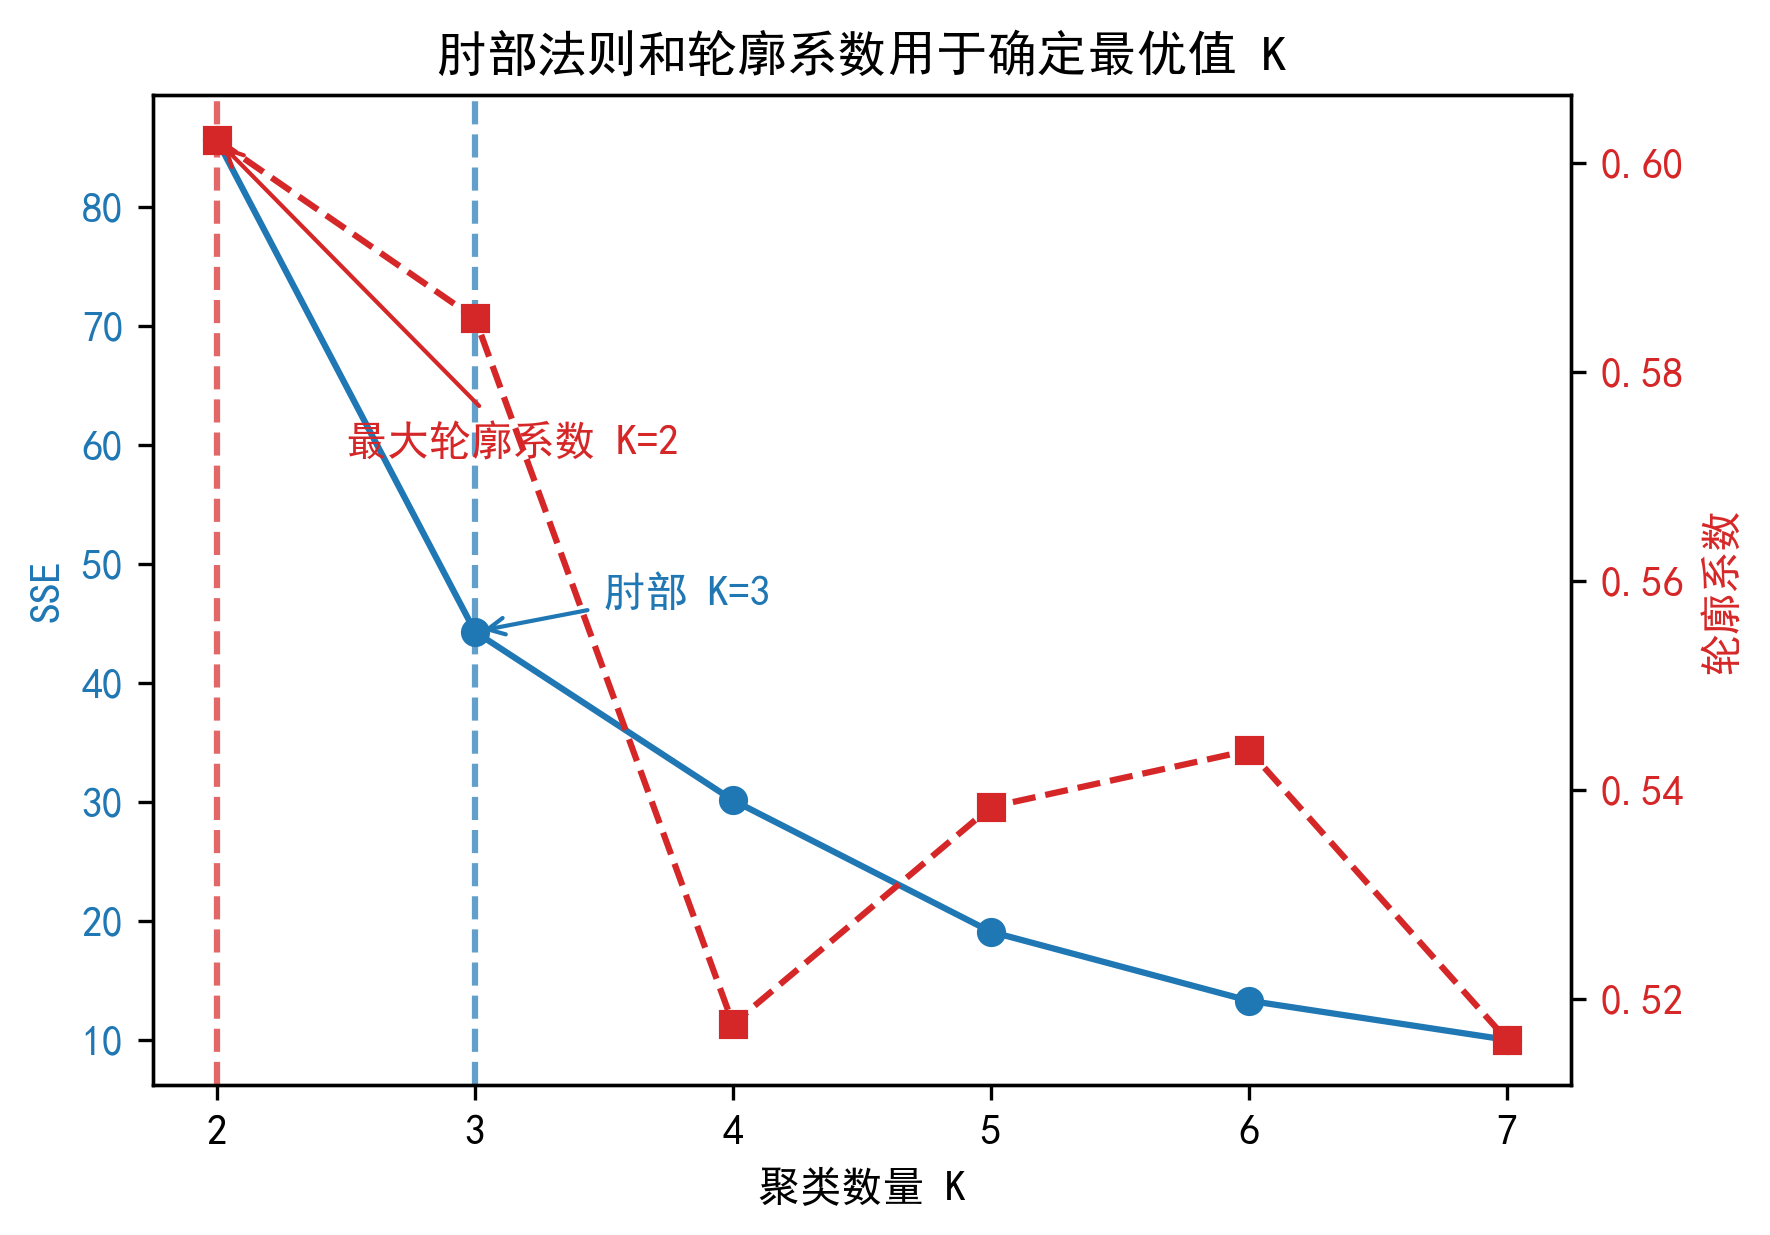

In [74]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import numpy as np


# 设置中文字体为黑体（SimHei），解决中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False



# ===== 1. 数据准备（标准化） =====
X = df_unique[['BMI']].values
X = (X - X.mean()) / X.std()

# ===== 2. 计算 SSE 和 轮廓系数 =====
sse = []
sil_scores = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=4,
        random_state=42,
        algorithm='elkan'
    )
    labels = km.fit_predict(X)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# ===== 3. 自动检测最佳 K =====
kl = KneeLocator(K_range, sse, curve="convex", direction="decreasing")
best_k_elbow = kl.knee
best_k_sil = K_range[np.argmax(sil_scores)]

fig, ax1 = plt.subplots(figsize=(6,4), dpi=300)

# 左轴 - SSE
color = 'tab:blue'
ax1.set_xlabel(r'聚类数量 K')
ax1.set_ylabel(r'SSE', color=color)
ax1.plot(K_range, sse, 'o-', color=color, label='SSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(best_k_elbow, color=color, linestyle='--', alpha=0.7)
ax1.annotate(fr'肘部 K={best_k_elbow}',
             xy=(best_k_elbow, sse[best_k_elbow-2]),
             xytext=(best_k_elbow+0.5, sse[best_k_elbow-2]*1.05),
             arrowprops=dict(arrowstyle='->', color=color),
             fontsize=10, color=color)

# 右轴 - Silhouette Score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'轮廓系数', color=color)
ax2.plot(K_range, sil_scores, 's--', color=color, label='轮廓系数')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axvline(best_k_sil, color=color, linestyle='--', alpha=0.7)
ax2.annotate(fr'最大轮廓系数 K={best_k_sil}',
             xy=(best_k_sil, sil_scores[best_k_sil-2]),
             xytext=(best_k_sil+0.5, sil_scores[best_k_sil-2]*0.95),
             arrowprops=dict(arrowstyle='->', color=color),
             fontsize=10, color=color)

# 图例
fig.tight_layout()
plt.title(r'肘部法则和轮廓系数用于确定最优值 K')
plt.savefig('optimal_k_plot.png', dpi=300, bbox_inches='tight')
plt.show()


选择3作为聚类的个数

In [75]:
K = 5
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# ===== 1. 数据准备（标准化） =====
X = df_unique[['BMI']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# ===== 2. KMeans 聚类（K=3） =====
kmeans = KMeans(
    n_clusters=K,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm='elkan'
)
labels = kmeans.fit_predict(X_scaled)
# ===== 3. 将聚类标签加入 DataFrame =====
df_unique['BMI_group'] = labels
# ===== 4. 聚类效果评估 =====
sil_score = silhouette_score(X_scaled, labels)
print(f"轮廓系数: {sil_score:.3f}")
# ===== 5. 分组统计（按 BMI 从小到大排序） =====
group_stats = df_unique.groupby('BMI_group')['BMI'].agg(
    min='min',
    max='max',
    mean='mean',
    size='count',
    std='std'
).sort_values('min')
print(group_stats)
# ===== 6. 如果你想按 BMI 从小到大重新编号分组 =====

轮廓系数: 0.538
                 min        max       mean  size       std
BMI_group                                                 
2          26.606024  29.412320  28.564948    62  0.656301
1          29.489589  31.446499  30.296761    78  0.551655
4          31.516706  33.822347  32.607069    66  0.634893
0          33.900862  36.856670  35.106523    37  0.864102
3          37.151452  43.484567  39.016542     9  2.186985


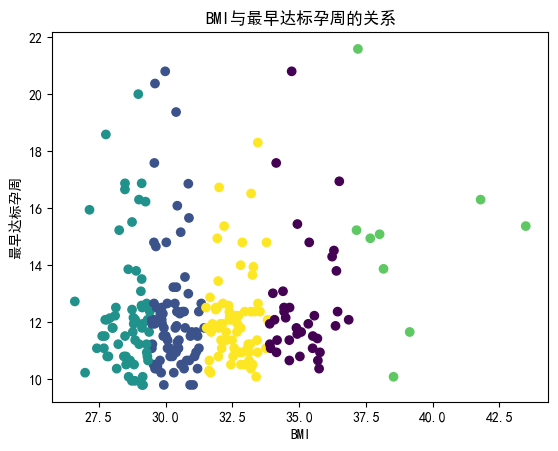

In [76]:


# 获取每组的位置
group_positions = df_unique.groupby('BMI_group').mean().sort_values('BMI')['BMI'].index

# 绘制散点图
plt.scatter(df_unique['BMI'], df_unique['最早达标孕周'], c=df_unique['BMI_group'], cmap='viridis')

# 绘制聚类中心
#plt.scatter(group_positions, df_unique.groupby('BMI_group').mean().sort_values('BMI')['最早达标孕周'], marker='x', s=100, c='red')

# 添加标签
plt.xlabel('BMI')
plt.ylabel('最早达标孕周')
plt.title('BMI与最早达标孕周的关系')

# 显示图形
plt.show()


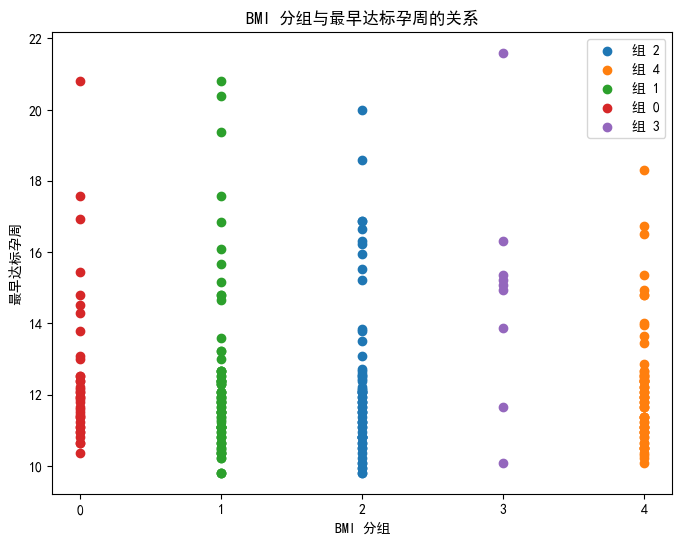

In [77]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 获取分组编号（假设 BMI_group 是整数 0,1,2,...）
groups = df_unique['BMI_group'].unique()

plt.figure(figsize=(8,6))
for g in groups:
    group_data = df_unique[df_unique['BMI_group'] == g]
    # 横坐标全是组编号 g
    plt.scatter([g]*len(group_data), group_data['最早达标孕周'], label=f'组 {g}')

plt.xticks(groups)  # 横坐标显示组编号
plt.xlabel('BMI 分组')
plt.ylabel('最早达标孕周')
plt.title('BMI 分组与最早达标孕周的关系')
plt.legend()
plt.show()


In [78]:
import numpy as np
import pandas as pd

def find_best_time(group_data, delta=2, w1=0.6, w2=0.4):
    weeks = np.arange(9, 20, 0.1)  # 枚举检测孕周
    risks = []
    for t in weeks:
        early_risk = np.mean(group_data > t)       # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        risks.append(total_risk)
    best_idx = np.argmin(risks)
    return weeks[best_idx], risks[best_idx]

# 假设 df_unique 有 BMI_group 和 最早达标孕周
best_times = []
for g, sub in df_unique.groupby('BMI_group'):
    best_t, min_risk = find_best_time(sub['最早达标孕周'].values)
    best_times.append({
        'BMI_group': g,
        'BMI_min': sub['BMI'].min(),
        'BMI_max': sub['BMI'].max(),
        '最佳孕周': best_t,
        '最小风险值': min_risk
    })

best_times_df = pd.DataFrame(best_times)
print(best_times_df)


   BMI_group    BMI_min    BMI_max  最佳孕周     最小风险值
0          0  33.900862  36.856670  12.6  0.172973
1          1  29.489589  31.446499  12.7  0.192308
2          2  26.606024  29.412320  12.8  0.212903
3          3  37.151452  43.484567  16.4  0.200000
4          4  31.516706  33.822347  12.7  0.169697


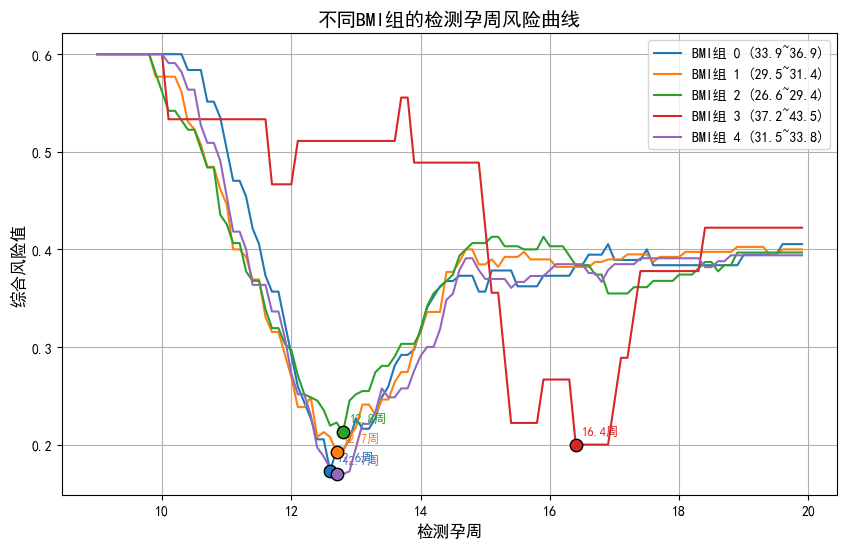

,BMI_group,BMI_min,BMI_max,最佳孕周,最小风险值
0,0,33.900862,36.856670,12.6,0.172973
1,1,29.489589,31.446499,12.7,0.192308
2,2,26.606024,29.412320,12.8,0.212903
3,3,37.151452,43.484567,16.4,0.200000
4,4,31.516706,33.822347,12.7,0.169697


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 风险计算函数
# ---------------------------
def find_best_time_curve(group_data, delta=2, w1=0.6, w2=0.4):
    """
    输入：
        group_data: 该BMI组的最早达标孕周数组
        delta: 晚检延迟阈值（周）
        w1, w2: 早检风险与晚检风险权重
    输出：
        weeks: 孕周数组
        risks: 对应风险值数组
        best_t: 最佳孕周
        min_risk: 最小风险值
    """
    weeks = np.arange(9, 20, 0.1)  # 枚举检测孕周
    risks = []
    for t in weeks:
        early_risk = np.mean(group_data > t)       # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        risks.append(total_risk)
    risks = np.array(risks)
    best_idx = np.argmin(risks)
    return weeks, risks, weeks[best_idx], risks[best_idx]

# ---------------------------
# 绘制风险曲线
# ---------------------------
plt.figure(figsize=(10, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 每组颜色
best_points = []

for i, (g, sub) in enumerate(df_unique.groupby('BMI_group')):
    weeks, risks, best_t, min_risk = find_best_time_curve(sub['最早达标孕周'].values)
    plt.plot(weeks, risks, label=f'BMI组 {g} ({sub["BMI"].min():.1f}~{sub["BMI"].max():.1f})', color=colors[i])
    plt.scatter(best_t, min_risk, color=colors[i], s=80, edgecolors='k', zorder=5)
    plt.text(best_t+0.1, min_risk+0.01, f'{best_t:.1f}周', fontsize=9, color=colors[i])
    best_points.append((g, sub["BMI"].min(), sub["BMI"].max(), best_t, min_risk))

plt.xlabel('检测孕周', fontsize=12)
plt.ylabel('综合风险值', fontsize=12)
plt.title('不同BMI组的检测孕周风险曲线', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 输出最佳孕周表格
# ---------------------------
best_df = pd.DataFrame(best_points, columns=['BMI_group', 'BMI_min', 'BMI_max', '最佳孕周', '最小风险值'])
display(best_df)


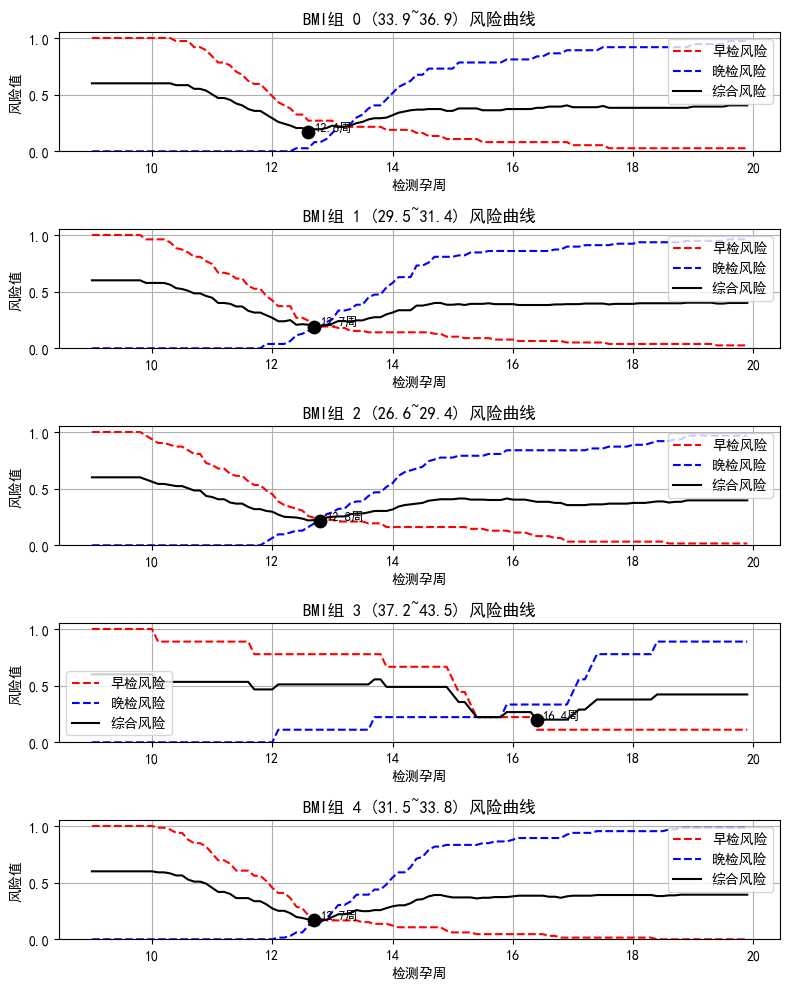

,BMI_group,BMI_min,BMI_max,最佳孕周,最小风险值


In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 风险计算函数（返回分解曲线）
# ---------------------------
def find_best_time_curve_detail(group_data, delta=2, w1=0.6, w2=0.4):
    weeks = np.arange(9, 20, 0.1)  # 检测孕周范围
    early_risks = []
    late_risks = []
    total_risks = []
    
    for t in weeks:
        early_risk = np.mean(group_data > t)        # 未达标比例
        late_risk = np.mean(group_data < t - delta) # 延误比例
        total_risk = w1 * early_risk + w2 * late_risk
        
        early_risks.append(early_risk)
        late_risks.append(late_risk)
        total_risks.append(total_risk)
    
    early_risks = np.array(early_risks)
    late_risks = np.array(late_risks)
    total_risks = np.array(total_risks)
    
    best_idx = np.argmin(total_risks)
    return weeks, early_risks, late_risks, total_risks, weeks[best_idx], total_risks[best_idx]

# ---------------------------
# 绘制每个BMI组的风险分解曲线
# ---------------------------
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
best_points = []


fig, axs = plt.subplots(len(df_unique.BMI_group.unique()), 1, figsize=(8, 10))
for i, (g, sub) in enumerate(df_unique.groupby('BMI_group')):
    weeks, early_risks, late_risks, total_risks, best_t, min_risk = find_best_time_curve_detail(
        sub['最早达标孕周'].values
    )
    
    axs[i].plot(weeks, early_risks, '--', color='red', label='早检风险')
    axs[i].plot(weeks, late_risks, '--', color='blue', label='晚检风险')
    axs[i].plot(weeks, total_risks, '-', color='black', label='综合风险')
    
    # 标注最佳孕周
    axs[i].scatter(best_t, min_risk, color='black', s=80, edgecolors='k', zorder=5)
    axs[i].text(best_t+0.1, min_risk+0.01, f'{best_t:.1f}周', fontsize=9, color='black')
    
    axs[i].set_title(f'BMI组 {g} ({sub["BMI"].min():.1f}~{sub["BMI"].max():.1f}) 风险曲线')
    axs[i].set_xlabel('检测孕周')
    axs[i].set_ylabel('风险值')
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

# ---------------------------
# 输出最佳孕周表格
# ---------------------------
best_df = pd.DataFrame(best_points, columns=['BMI_group', 'BMI_min', 'BMI_max', '最佳孕周', '最小风险值'])
display(best_df)
